In [1]:
# silencing some logs/warning
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
%env WANDB_SILENT=True

from typing import Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import wandb

from process_data import process_data
from evaluate import evaluate_pred, print_dummy_evaluations
from visualization import plot_confusion_matrix
from utils.constants import SEED

env: WANDB_SILENT=True


In [2]:
wandb.login()

True

In [3]:
split_prec = {
    'train': 0.7, 
    'valid': 0.15, 
    'test': 0.15
}
scaler = None

X_train, X_valid, X_test, Y_train, Y_valid, Y_test = process_data(split_prec, scaler)

columns = X_train.columns.to_list()

Dropped columns:

 ['snow']
New columns: ['temp_fahrenheit']
Split: "train" 	[Size: 1120] 	[Prec: 0.7]
	X: (1120, 15)
	Y: (1120,)
Split: "valid" 	[Size: 239] 	[Prec: 0.149375]
	X: (239, 15)
	Y: (239,)
Split: "test" 	[Size: 241] 	[Prec: 0.150625]
	X: (241, 15)
	Y: (241,)


In [4]:
PROJECT_NAME = 'SML'
PROJECT_ENTITY = 'calebcaulk02-uppsala-universitet'

GOAL_METRIC = 'accuracy'
sweep_configuration = {
    'method': 'bayes',
    'metric': {'goal': 'maximize', 'name': GOAL_METRIC},
    'parameters': {
        'n_estimators': {'max':150, 'min': 5},
        'criterion': {'values': ['gini', 'entropy', 'log_loss']},
        'max_depth': {'max': 100, 'min': 1},
        'min_samples_split': {'max': 8, 'min': 2},
        'min_samples_leaf': {'max': 8, 'min': 1},
        'max_features': {'values': ['sqrt', 'log2', None]},
    }
}

sweep_id = wandb.sweep(
    project=PROJECT_NAME,
    sweep=sweep_configuration
)

Create sweep with ID: m3ndbxda
Sweep URL: https://wandb.ai/calebcaulk02-uppsala-universitet/SML/sweeps/m3ndbxda


# Random Forest
Parts:
1. Train the model
2. Tune the model
3. Evaluate the model

In [5]:
# sweeping
def objective(config):
    # creating the model
    model = RandomForestClassifier(
        n_estimators=config.n_estimators,
        criterion=config.criterion,
        max_depth=config.max_depth,
        min_samples_split=config.min_samples_split,
        min_samples_leaf=config.min_samples_leaf,
        max_features=config.max_features,
        random_state=SEED
    )

    # training
    model.fit(X_train, Y_train)
    
    # evaluating
    y_pred = model.predict(X_valid)
    y_true = Y_valid
    metrics = evaluate_pred(y_pred, y_true)
    return metrics

def main():
    run = wandb.init(
      project=PROJECT_NAME,
      config={
          'splits': split_prec,
          'scaler': scaler,
          'columns': columns
      }
    )
    metrics = objective(wandb.config)
    wandb.log(metrics)


# start sweeping
wandb.agent(sweep_id, function=main, count=3)
wandb.finish()

In [6]:
## get best parameters/run
api = wandb.Api()
sweep = api.sweep(f'{PROJECT_ENTITY}/{PROJECT_NAME}/sweeps/{sweep_id}')
best_run = sweep.best_run(order=GOAL_METRIC)

print('Best hyperparameters:')
best_parameters = best_run.config
non_model_parameters = ['scaler', 'splits', 'columns']
hyperparameters = {}
for param, value in best_parameters.items():
    print(f'{param}: {value}')
    # correct parameters, so only model hyperparameters are included
    if param not in non_model_parameters:
        hyperparameters[param] = value

print('\nMetrics:')
best_metrics = best_run.summary
for param, value in best_metrics.items():
    if '_' != param[0]:
        print(f'{param}: {value}')

Best hyperparameters:
scaler: None
splits: {'test': 0.15, 'train': 0.7, 'valid': 0.15}
columns: ['hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'temp_fahrenheit']
criterion: log_loss
max_depth: 61
max_features: log2
n_estimators: 102
min_samples_leaf: 7
min_samples_split: 6

Metrics:
accuracy: 0.891213389121339
precision: 0.7878787878787878
recall: 0.5777777777777777


### Training

In [7]:
model = RandomForestClassifier(**hyperparameters, random_state=SEED)
model.fit(X_train, Y_train)

RandomForestClassifier(criterion='log_loss', max_depth=61, max_features='log2',
                       min_samples_leaf=7, min_samples_split=6,
                       n_estimators=102, random_state=1)

### Evaluating

In [8]:
y_pred = model.predict(X_test)
y_true = Y_test

metrics = evaluate_pred(y_pred, y_true)

print('-- Random Forest model --\n')
for metric, value in metrics.items():
    print(f'{metric.capitalize()}: \t{value}')

print('\n-- Dummy models -- ')
print_dummy_evaluations(X_train, Y_train, X_test, Y_test)

-- Random Forest model --

Accuracy: 	0.9045643153526971
Recall: 	0.5555555555555556
Precision: 	0.7407407407407407

-- Dummy models -- 

Most_frequent
  Accuracy: 	0.8506224066390041
  Recall: 	0.0
  Precision: 	0.0

Stratified
  Accuracy: 	0.7053941908713693
  Recall: 	0.16666666666666666
  Precision: 	0.1276595744680851

Uniform
  Accuracy: 	0.4315352697095436
  Recall: 	0.3333333333333333
  Precision: 	0.096


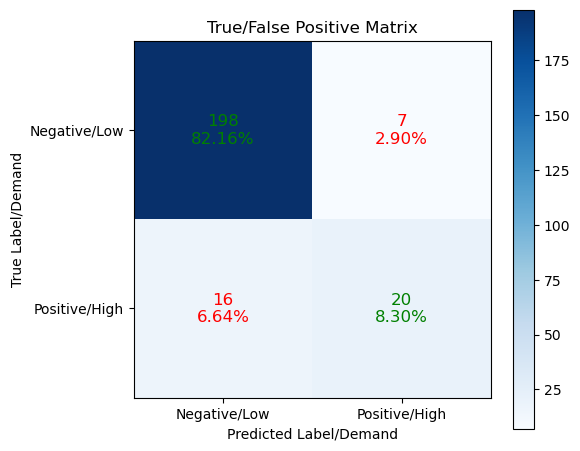

True Positive (TP): 20
True Negative (TN): 198
False Positive (FP): 7
False Negative (FN): 16


In [9]:
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
confusion_matrix_data = np.array([[tn, fp], [fn, tp]])
plot_confusion_matrix(confusion_matrix_data)

print(f'True Positive (TP): {tp}')
print(f'True Negative (TN): {tn}')
print(f'False Positive (FP): {fp}')
print(f'False Negative (FN): {fn}')